# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [ ]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d startjapan/ff1010bird-duration7

 97% 201M/206M [00:06<00:00, 30.8MB/s]
100% 206M/206M [00:06<00:00, 34.2MB/s]


In [ ]:
! mkdir /content/ff1010bird-duration7
! unzip /content/ff1010bird-duration7.zip -d /content/ff1010bird-duration7

Streaming output truncated to the last 5000 lines.
  inflating: /content/ff1010bird-duration7/nocall/127208.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127209.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127210.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127228.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127229.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127230.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127231.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127233.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127234.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127236.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127237.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127238.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127239.wav.npy  
  inflating: /content/ff1010bird-duration7/nocall/127240.wav.npy  
  inflating

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir /content/drive/MyDrive/no_call_model


In [ ]:
import os

OUTPUT_DIR = '/content/drive/MyDrive/no_call_model'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
else:
    print("Exists!")

Exists!


In [ ]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('/content/ff1010bird-duration7/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '/content/ff1010bird-duration7/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '/content/ff1010bird-duration7/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [ ]:
#!pip install -U albumentations
!pip install "opencv-python-headless<4.3"

     |████████████████████████████████| 21.6 MB 10.9 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

!pip install timm
import timm

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [ ]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [ ]:
def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [ ]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_a1h-0146ab0a.pth


Epoch: [1][1/192] Data 1.060 (1.060) Elapsed 0m 2s (remain 7m 17s) Loss: 0.6861(0.6861) Grad: 44.5485  
Epoch: [1][101/192] Data 0.000 (0.012) Elapsed 1m 48s (remain 1m 37s) Loss: 0.3575(0.5313) Grad: 13.0887  
Epoch: [1][192/192] Data 0.000 (0.006) Elapsed 3m 24s (remain 0m 0s) Loss: 0.5538(0.4702) Grad: 20.6289  
EVAL: [1/49] Data 0.465 (0.465) Elapsed 0m 0s (remain 0m 35s) Loss: 0.4088(0.4088) 


Epoch 1 - avg_train_loss: 0.4702  avg_val_loss: 0.3643  time: 218s
Epoch 1 - Accuracy: 0.8654096228868661
Epoch 1 - Save Best Score: 0.8654 Model


EVAL: [49/49] Data 0.000 (0.010) Elapsed 0m 13s (remain 0m 0s) Loss: 0.8049(0.3643) 
Epoch: [2][1/192] Data 0.900 (0.900) Elapsed 0m 1s (remain 6m 9s) Loss: 0.3222(0.3222) Grad: 14.5239  
Epoch: [2][101/192] Data 0.001 (0.009) Elapsed 1m 47s (remain 1m 36s) Loss: 0.2434(0.3530) Grad: 10.2453  
Epoch: [2][192/192] Data 0.000 (0.005) Elapsed 3m 23s (remain 0m 0s) Loss: 0.4572(0.3325) Grad: 14.0809  
EVAL: [1/49] Data 0.330 (0.330) Elapsed 0m 0s (remain 0m 28s) Loss: 0.3351(0.3351) 


Epoch 2 - avg_train_loss: 0.3325  avg_val_loss: 0.3489  time: 217s
Epoch 2 - Accuracy: 0.864109232769831


EVAL: [49/49] Data 0.000 (0.007) Elapsed 0m 13s (remain 0m 0s) Loss: 1.0104(0.3489) 
Epoch: [3][1/192] Data 0.805 (0.805) Elapsed 0m 1s (remain 5m 54s) Loss: 0.2430(0.2430) Grad: 10.5988  
Epoch: [3][101/192] Data 0.000 (0.008) Elapsed 1m 47s (remain 1m 36s) Loss: 0.2676(0.3147) Grad: 10.8826  
Epoch: [3][192/192] Data 0.000 (0.004) Elapsed 3m 23s (remain 0m 0s) Loss: 0.4301(0.2954) Grad: 14.8959  
EVAL: [1/49] Data 0.350 (0.350) Elapsed 0m 0s (remain 0m 29s) Loss: 0.3781(0.3781) 


Epoch 3 - avg_train_loss: 0.2954  avg_val_loss: 0.3411  time: 217s
Epoch 3 - Accuracy: 0.8790637191157347
Epoch 3 - Save Best Score: 0.8791 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 13s (remain 0m 0s) Loss: 0.4425(0.3411) 
Epoch: [4][1/192] Data 1.000 (1.000) Elapsed 0m 2s (remain 6m 32s) Loss: 0.1935(0.1935) Grad: 9.4436  
Epoch: [4][101/192] Data 0.000 (0.010) Elapsed 1m 47s (remain 1m 36s) Loss: 0.2584(0.2765) Grad: 14.1913  
Epoch: [4][192/192] Data 0.000 (0.006) Elapsed 3m 23s (remain 0m 0s) Loss: 0.3376(0.2643) Grad: 13.0136  
EVAL: [1/49] Data 0.392 (0.392) Elapsed 0m 0s (remain 0m 31s) Loss: 0.4142(0.4142) 


Epoch 4 - avg_train_loss: 0.2643  avg_val_loss: 0.3377  time: 217s
Epoch 4 - Accuracy: 0.8797139141742523
Epoch 4 - Save Best Score: 0.8797 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 13s (remain 0m 0s) Loss: 0.5394(0.3377) 
Epoch: [5][1/192] Data 1.139 (1.139) Elapsed 0m 2s (remain 6m 55s) Loss: 0.1996(0.1996) Grad: 9.8959  
Epoch: [5][101/192] Data 0.000 (0.012) Elapsed 1m 47s (remain 1m 36s) Loss: 0.1965(0.2421) Grad: 11.5094  
Epoch: [5][192/192] Data 0.000 (0.006) Elapsed 3m 23s (remain 0m 0s) Loss: 0.2589(0.2349) Grad: 13.0854  
EVAL: [1/49] Data 0.394 (0.394) Elapsed 0m 0s (remain 0m 31s) Loss: 0.3541(0.3541) 


Epoch 5 - avg_train_loss: 0.2349  avg_val_loss: 0.3423  time: 217s
Epoch 5 - Accuracy: 0.8842652795838751
Epoch 5 - Save Best Score: 0.8843 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1213(0.3423) 
Epoch: [6][1/192] Data 1.023 (1.023) Elapsed 0m 2s (remain 6m 33s) Loss: 0.2180(0.2180) Grad: 11.9510  
Epoch: [6][101/192] Data 0.000 (0.011) Elapsed 1m 47s (remain 1m 36s) Loss: 0.1620(0.2198) Grad: 9.2514  
Epoch: [6][192/192] Data 0.000 (0.006) Elapsed 3m 23s (remain 0m 0s) Loss: 0.2215(0.2039) Grad: 11.2822  
EVAL: [1/49] Data 0.403 (0.403) Elapsed 0m 0s (remain 0m 31s) Loss: 0.4279(0.4279) 


Epoch 6 - avg_train_loss: 0.2039  avg_val_loss: 0.3500  time: 217s
Epoch 6 - Accuracy: 0.88296488946684


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 13s (remain 0m 0s) Loss: 0.3923(0.3500) 
Epoch: [7][1/192] Data 0.938 (0.938) Elapsed 0m 1s (remain 6m 17s) Loss: 0.1326(0.1326) Grad: 8.4532  
Epoch: [7][101/192] Data 0.000 (0.010) Elapsed 1m 47s (remain 1m 36s) Loss: 0.1431(0.1861) Grad: 12.7204  
Epoch: [7][192/192] Data 0.000 (0.005) Elapsed 3m 23s (remain 0m 0s) Loss: 0.1403(0.1702) Grad: 8.7846  
EVAL: [1/49] Data 0.299 (0.299) Elapsed 0m 0s (remain 0m 27s) Loss: 0.4191(0.4191) 


Epoch 7 - avg_train_loss: 0.1702  avg_val_loss: 0.3509  time: 217s
Epoch 7 - Accuracy: 0.8810143042912874


EVAL: [49/49] Data 0.000 (0.007) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1153(0.3509) 
Epoch: [8][1/192] Data 0.972 (0.972) Elapsed 0m 2s (remain 6m 22s) Loss: 0.2193(0.2193) Grad: 22.5054  
Epoch: [8][101/192] Data 0.000 (0.010) Elapsed 1m 47s (remain 1m 36s) Loss: 0.1138(0.1678) Grad: 9.5279  
Epoch: [8][192/192] Data 0.000 (0.005) Elapsed 3m 23s (remain 0m 0s) Loss: 0.3329(0.1524) Grad: 23.1491  
EVAL: [1/49] Data 0.403 (0.403) Elapsed 0m 0s (remain 0m 32s) Loss: 0.3980(0.3980) 


Epoch 8 - avg_train_loss: 0.1524  avg_val_loss: 0.3648  time: 217s
Epoch 8 - Accuracy: 0.8810143042912874


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1469(0.3648) 
Epoch: [9][1/192] Data 0.761 (0.761) Elapsed 0m 1s (remain 5m 46s) Loss: 0.1566(0.1566) Grad: 14.3835  
Epoch: [9][101/192] Data 0.000 (0.008) Elapsed 1m 47s (remain 1m 36s) Loss: 0.1611(0.1478) Grad: 13.2321  
Epoch: [9][192/192] Data 0.000 (0.004) Elapsed 3m 23s (remain 0m 0s) Loss: 0.1722(0.1375) Grad: 17.3157  
EVAL: [1/49] Data 0.444 (0.444) Elapsed 0m 0s (remain 0m 34s) Loss: 0.4180(0.4180) 


Epoch 9 - avg_train_loss: 0.1375  avg_val_loss: 0.3635  time: 217s
Epoch 9 - Accuracy: 0.8764629388816645


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1333(0.3635) 
Epoch: [10][1/192] Data 1.034 (1.034) Elapsed 0m 2s (remain 6m 34s) Loss: 0.0829(0.0829) Grad: 7.7769  
Epoch: [10][101/192] Data 0.000 (0.011) Elapsed 1m 47s (remain 1m 36s) Loss: 0.0738(0.1428) Grad: 6.8406  
Epoch: [10][192/192] Data 0.000 (0.006) Elapsed 3m 23s (remain 0m 0s) Loss: 0.2793(0.1313) Grad: 19.3020  
EVAL: [1/49] Data 0.459 (0.459) Elapsed 0m 0s (remain 0m 34s) Loss: 0.4039(0.4039) 


Epoch 10 - avg_train_loss: 0.1313  avg_val_loss: 0.3651  time: 217s
Epoch 10 - Accuracy: 0.8745123537061118


EVAL: [49/49] Data 0.000 (0.010) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1281(0.3651) 


========== CV ==========
Score: 0.88427


TN 1114
FP 37
FN 141
TP 246


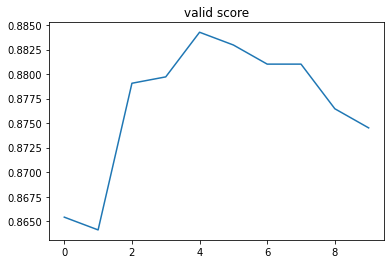

In [ ]:
if __name__ == '__main__':
    main(0)